# Looping to make a new map
Unfortunately or fortunately, I am focusing on transportation barriers so the graph that I want to make revolves around walking distance just like the example in class. I will try to spice it up a little bit but the first buncha steps are going to be the same.

In [1]:
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

# for interactive webmaps
import folium

In [2]:
latlon = [33.94566367255709, -118.18660315690217] # Already Centered on the best park in District 2 according to our metrics: South Gate Park
network_type = 'drive' # Change network type because I am focusing on transportation
trip_times = [5, 10, 15] #in minutes, 
meters_per_minute = 670 # travel distance per minute for a car going 25 mph

In [3]:
G = ox.graph_from_point(latlon, network_type=network_type, dist = 4000) # expand bc im in a car

In [4]:
G = ox.project_graph(G, to_crs='epsg:3857')

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [6]:
# get the bounding box coordinates
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13161292.44265084
4016686.060215743
-13151657.673930988
4026336.442644259


In [7]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13156475.058290914
4021511.251430001


In [8]:
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x) # Defining this for later, just as the park center

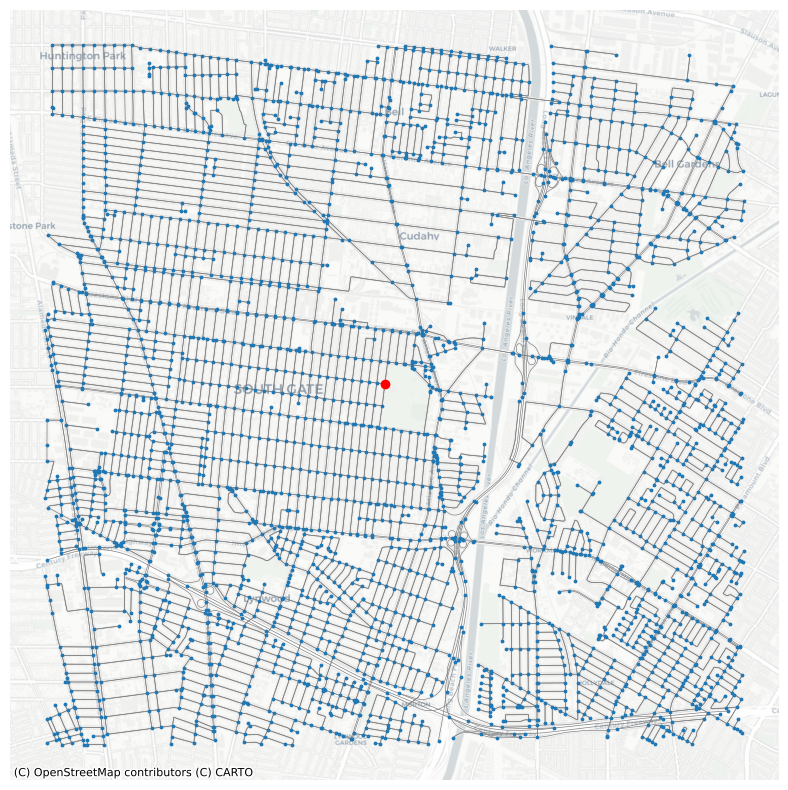

In [9]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5, # don't do more than 1
               edgecolor='gray', # line color
               zorder=10) #3D position (layers)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=3, 
               zorder=20) #this is higher so goes over the lines

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30) # top-most layers

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

# post note: that worked out well because the centroid is focused on the parking lot entrance to the park, where drivers would access it. 

In [10]:
gdf_edges['drive_time'] = gdf_edges['length']/meters_per_minute

In [11]:
gdf_edges[['osmid','name','highway','length','drive_time']].sample(15)

,,,osmid,name,highway,length,drive_time
u,v,key,,,,,
123278800,123278797,0,398534625,State Street,secondary,91.465,0.136515
5226116494,4026675941,0,1192240675,Garfield Avenue,secondary,20.893,0.031184
123114961,123114957,0,"[1072219808, 404029823]",Long Beach Boulevard,primary,60.452,0.090227
123369120,74873416,0,"[398407120, 776460621]",Gage Avenue,secondary,62.783,0.093706
123207331,123544590,0,967565310,Bear Avenue,tertiary,102.338,0.152743
122901120,122901117,0,13334258,Woodlawn Avenue,residential,76.164,0.113678
122790649,123519938,0,403691473,Downey Avenue,secondary,55.470,0.082791
122882640,122882648,0,13330664,Hondo Street,residential,84.652,0.126346
123006203,123408170,0,398571812,Old River School Road,secondary,115.696,0.172681


## I get it now.
It took me a while to understand this but I get it. The drive_time is a function of the length of the edges, not the time to get to the centroid. I have to say it again so I don't forget.

In [12]:
cmap = 'RdYlGn'

In [13]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15]
['#a50026', '#feffbe', '#006837']


In [14]:
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#a50026'), (10, '#feffbe'), (15, '#006837')]

In [15]:
for time,color in list(time_color):
    print('The color for a '+str(time)+' minute drive is ' + color) # change this a tiny bit for grammer

The color for a 5 minute drive is #a50026
The color for a 10 minute drive is #feffbe
The color for a 15 minute drive is #006837


In [16]:
time_color.reverse()

In [17]:
# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time,distance='time') #centernode is the park, defined earlier 

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' a minute drive ' + color)
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 395 nodes within 15 a minute drive #006837
There are 185 nodes within 10 a minute drive #feffbe
There are 48 nodes within 5 a minute drive #a50026


In [18]:
gdf_nodes.sample(10)

,y,x,ref,highway,street_count,lon,lat,geometry,time,color
osmid,,,,,,,,,,
1227593623,4.020347e+06,-1.315287e+07,NaN,NaN,3,-118.154210,33.937006,POINT (-13152866.459 4020346.591),NaN,nan
122584393,4.020681e+06,-1.315653e+07,NaN,NaN,4,-118.187122,33.939500,POINT (-13156530.284 4020681.244),5.0,#a50026
3602567427,4.022352e+06,-1.315618e+07,NaN,NaN,3,-118.183972,33.951954,POINT (-13156179.572 4022352.445),5.0,#a50026
123062155,4.021722e+06,-1.315259e+07,NaN,traffic_signals,3,-118.151769,33.947255,POINT (-13152594.773 4021721.805),NaN,nan
123345621,4.020535e+06,-1.315910e+07,NaN,NaN,3,-118.210200,33.938407,POINT (-13159099.248 4020534.560),NaN,nan
122926242,4.019767e+06,-1.316099e+07,NaN,NaN,3,-118.227207,33.932682,POINT (-13160992.459 4019766.508),NaN,nan
122883700,4.017650e+06,-1.315804e+07,NaN,NaN,3,-118.200718,33.916906,POINT (-13158043.773 4017649.942),NaN,nan
1227604966,4.018712e+06,-1.315361e+07,NaN,NaN,4,-118.160865,33.924823,POINT (-13153607.268 4018712.040),NaN,nan
122698391,4.017702e+06,-1.315193e+07,NaN,NaN,4,-118.145761,33.917294,POINT (-13151925.932 4017702.070),NaN,nan


In [19]:
gdf_nodes['color'] = gdf_nodes['color'].replace('nan', '#cccccc')
# replace all null values with grey, the blankest color

In [20]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones
# make the polygons by the time intervals

,geometry,y,x,ref,highway,street_count,lon,lat,color
time,,,,,,,,,
5.0,"MULTIPOINT ((-13157167.054 4021730.728), (-131...",4.020724e+06,-1.315686e+07,None,stop,4,-118.190079,33.939818,#a50026
10.0,"MULTIPOINT ((-13157866.363 4022568.791), (-131...",4.020811e+06,-1.315751e+07,None,traffic_signals,4,-118.195927,33.940469,#feffbe
15.0,"MULTIPOINT ((-13158504.324 4022645.743), (-131...",4.020044e+06,-1.315538e+07,12B,motorway_junction,3,-118.176768,33.934752,#006837


In [21]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones
# I honestly don't understand this step but it looks like it was to just keep 2 columns

,time,geometry
0,5.0,"POLYGON ((-13156674.053 4020339.761, -13156784..."
1,10.0,"POLYGON ((-13156542.017 4019543.575, -13156784..."
2,15.0,"POLYGON ((-13156787.877 4018627.749, -13157808..."


In [22]:
isochrones.sort_values(by='time', ascending=False,inplace=True)

In [23]:
iso_colors.reverse()
iso_colors

['#006837', '#feffbe', '#a50026']

# Add in other datasets

In [24]:
import pandas as pd 
import geopandas as gpd

In [25]:
Income = pd.read_excel(
    'Data/Income-Data.xlsx',
    dtype=
    {
        'GEO_ID':str,
    }
)
Income = Income.drop([0])
Income.info

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Income-Data.xlsx'

In [26]:
Tracts = gpd.read_file('Data/tl_2021_06_tract.zip')

Tracts1 = Tracts[['GEOID','geometry']]
Tracts1.columns = ['GEO_ID',
'geometry']
Tracts1.head()

DriverError: '/vsizip/Data/tl_2021_06_tract.zip' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
District2 = pd.read_excel('Data/District2.xlsx',
    dtype =
    {
        'CT20':str,
    }
)
District2['GEO_ID'] = '06' + '037' + District2['CT20']
District2.head()

In [ ]:
District2Tracts=Tracts1.merge(District2,on="GEO_ID")
District2Tracts.head()

In [ ]:
District2TractsGEO=District2Tracts.merge(Income,on="GEO_ID")
District2TractsGEO.head()

In [ ]:
VulnerableCar = pd.read_excel('Data/Transport.xlsx',
 dtype =
    {
        'TRACT':str,
    }
)
VulnerableCar['GEO_ID'] = '06' + '037' + VulnerableCar['TRACT']
VulnerableCar.head()

In [ ]:
District2VulnerableCar=District2TractsGEO.merge(VulnerableCar,on="GEO_ID")
District2VulnerableCar.info()

In [ ]:
m = folium.Map(location=latlon,zoom_start=15, tiles='Cartodb Positron')
# and here comes the wow factor...
isochrones.explore(m=m,column='time',cmap=cmap,categorical=True)
gdf_nodes.explore(m=m,column='time')